
ERT modeling and inversion in 2D
================================



Import necessary dependencies. pyGIMLi (www.pygimli.org) is used to create the
geometry as well as the modeling and inversion meshes.



In [5]:
import pybert as pb
import pygimli as pg
import pygimli.meshtools as mt  # save space

In [6]:
%matplotlib notebook
import matplotlib
import warnings
warnings.filterwarnings('ignore') # just to make it cleaner in the notebook

Create geometry definition for the modelling domain.
`worldMarker=True` indicates the default boundary conditions for the ERT



<IPython.core.display.Javascript object>


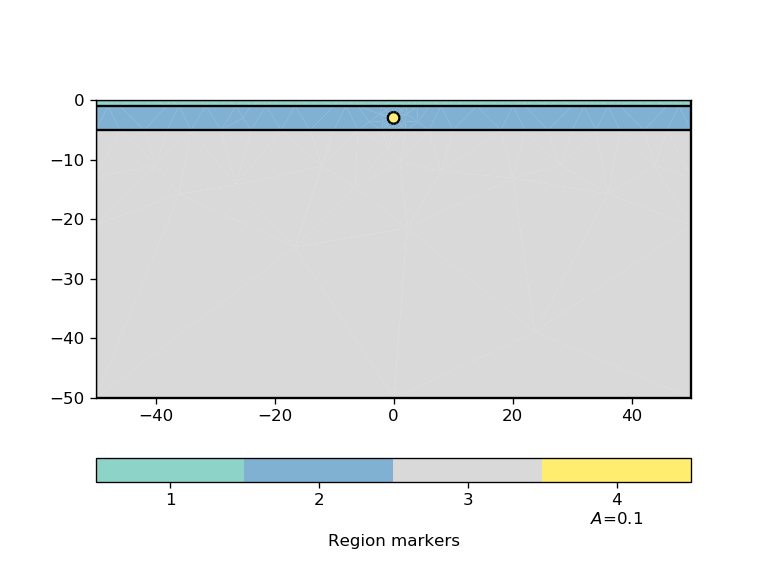

In [17]:
world = mt.createWorld(start=[-50, 0], end=[50, -50], layers=[-1, -5],
                       worldMarker=True)

# Create some heterogeneous circular anomaly
block = mt.createCircle(pos=[0, -3.], radius=1, marker=4, boundaryMarker=10,
                        area=0.1)

# Merge geometry definition into a Piecewise Linear Complex (PLC)
geom = mt.mergePLC([world, block])

# Optional: show the geometry
pg.show(geom);

Create a Dipole Dipole ('dd') measuring scheme with 21 electrodes.



In [18]:
scheme = pb.createData(elecs=pg.utils.grange(start=-10, end=10, n=21),
                       schemeName='dd')

Put all electrodes (aka. sensors positions) into the PLC to enforce mesh
refinement. Due to experience known, its convenient to add further refinement
nodes in a distance of 10% of electrode spacing, to achieve sufficient
numerical accuracy.



In [19]:
for pos in scheme.sensorPositions():
    geom.createNode(pos)
    geom.createNode(pos + pg.RVector3(0, -0.1))

Create a mesh for the finite element modelling with appropriate mesh quality.



<IPython.core.display.Javascript object>


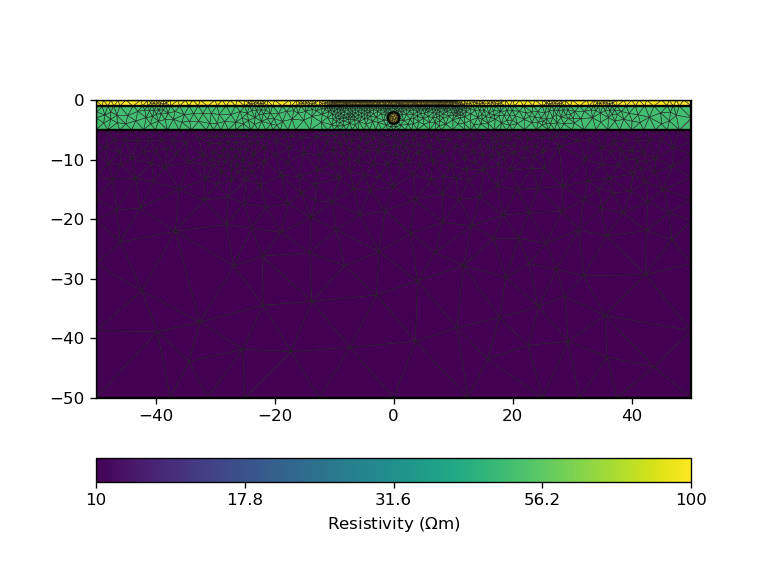

(<matplotlib.axes._subplots.AxesSubplot at 0x7f0dbe162c90>,
 <matplotlib.colorbar.Colorbar at 0x7f0dbe073250>)

In [20]:
mesh = mt.createMesh(geom, quality=34)

# Create a map to set resistivity values in the appropriate regions
# [[regionNumber, resistivity], [regionNumber, resistivity], [...]
rhomap = [[1, 100.],
          [2, 50.],
          [3, 10.],
          [4, 100.]]

# Optional: take a look at the mesh
pg.show(mesh, data=rhomap, label='Resistivity $(\Omega$m)', showMesh=True)

Initialize the ERTManager (The class name is a subject to further change!)



06/03/20 - 16:44:26 - pyGIMLi - WARNING - Module ps psutil not found.


relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Data error estimate (min:max)  0.010000195282949438 : 0.011090363058703112
Simulated rhoa 171 [95.74941920320374,...,19.369014706267254] 97.82959120081414
Filtered rhoa 171 [95.74941920320374,...,19.369014706267254] 97.82959120081414


<IPython.core.display.Javascript object>


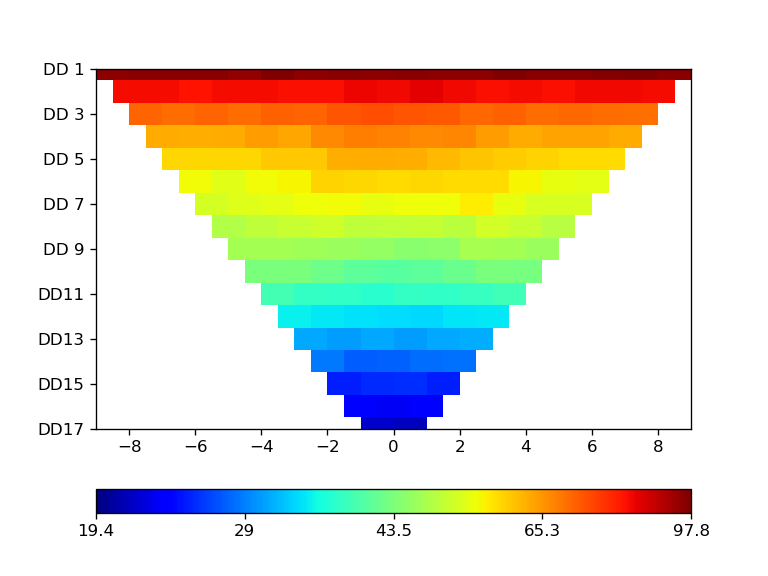

(<matplotlib.axes._subplots.AxesSubplot at 0x7f0dbe1d4310>,
 <matplotlib.colorbar.Colorbar at 0x7f0dbc407310>)

In [21]:
ert = pb.ERTManager()

# Perform the modeling with the mesh and the measuring scheme itself
# and return a data container with apparent resistivity values,
# geometric factors and estimated data errors specified by the noise setting.
# The noise is also added to the data.
data = ert.simulate(mesh, res=rhomap, scheme=scheme, noiseLevel=1,
                    noiseAbs=1e-6)

# Optional: you can filter all values and tokens in the data container.
print('Simulated rhoa', data('rhoa'), max(data('rhoa')))

# Its possible that there are some negative data values due to noise and
# huge geometric factors. So we need to remove them
data.markInvalid(data('rhoa') < 0)
print('Filtered rhoa', data('rhoa'), max(data('rhoa')))
data.removeInvalid()

# Optional: save the data for further use
data.save('simple.dat')

# Optional: take a look at the data
pb.show(data)

To avoid an inverse crime the inversion needs to be calculated on a different
mesh that has no geometric signatures of the simulation mesh.
Either let the inversion create a suitable mesh or provide a own.



creating mesh...
Mesh: Nodes: 1097 Cells: 2082 Boundaries: 3178
Mesh: Nodes: 1097 Cells: 2082 Boundaries: 3178


<IPython.core.display.Javascript object>


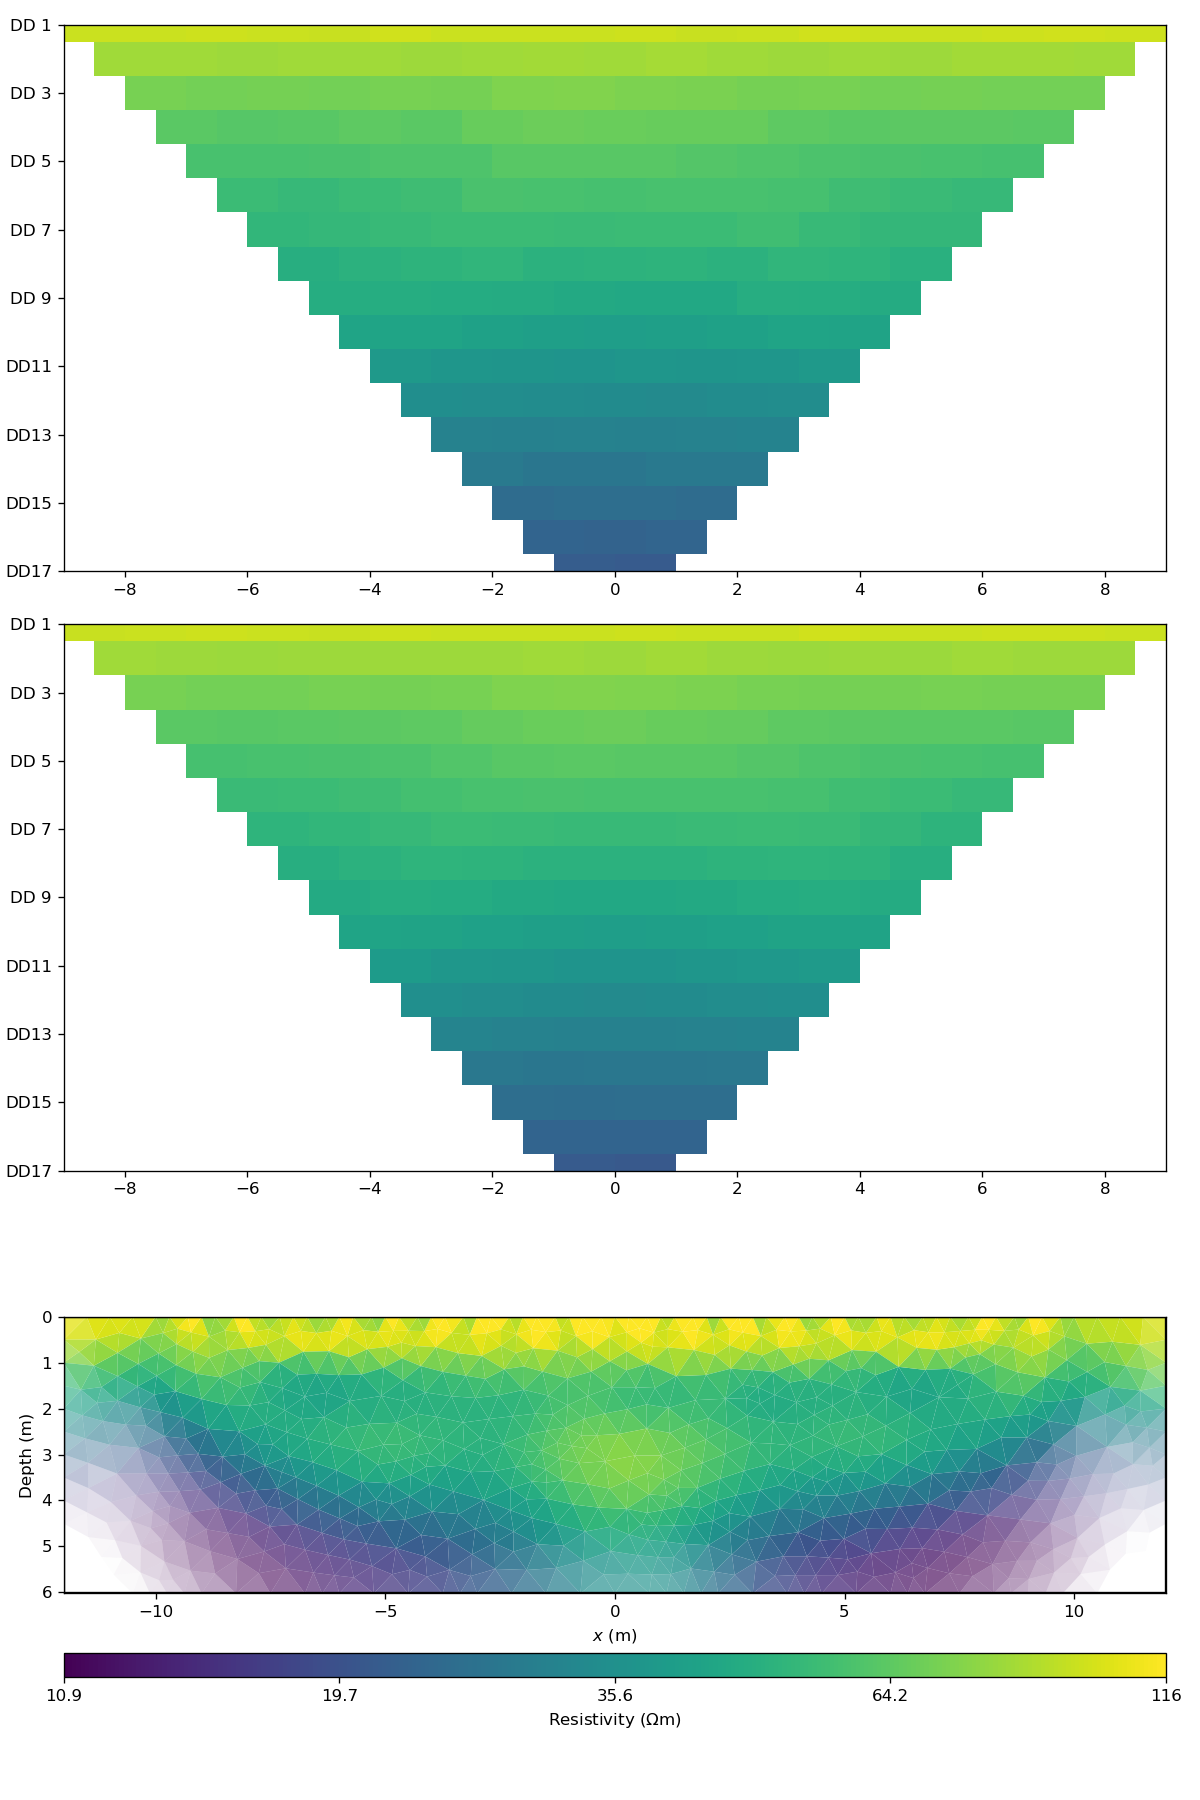

In [24]:
# Run the ERTManager to invert the modeled data.
# The necessary inversion mesh is generated automatic.
model = ert.invert(data, paraDX=0.3, maxCellArea=0.2, lam=20)

# Let the ERTManger show you the model and fitting results of the last
# successful run.
# Show data, model response, and model
ert.showResultAndFit()

Optional: provide a custom mesh to the inversion



Mesh: Nodes: 988 Cells: 1553 Boundaries: 2540


<IPython.core.display.Javascript object>


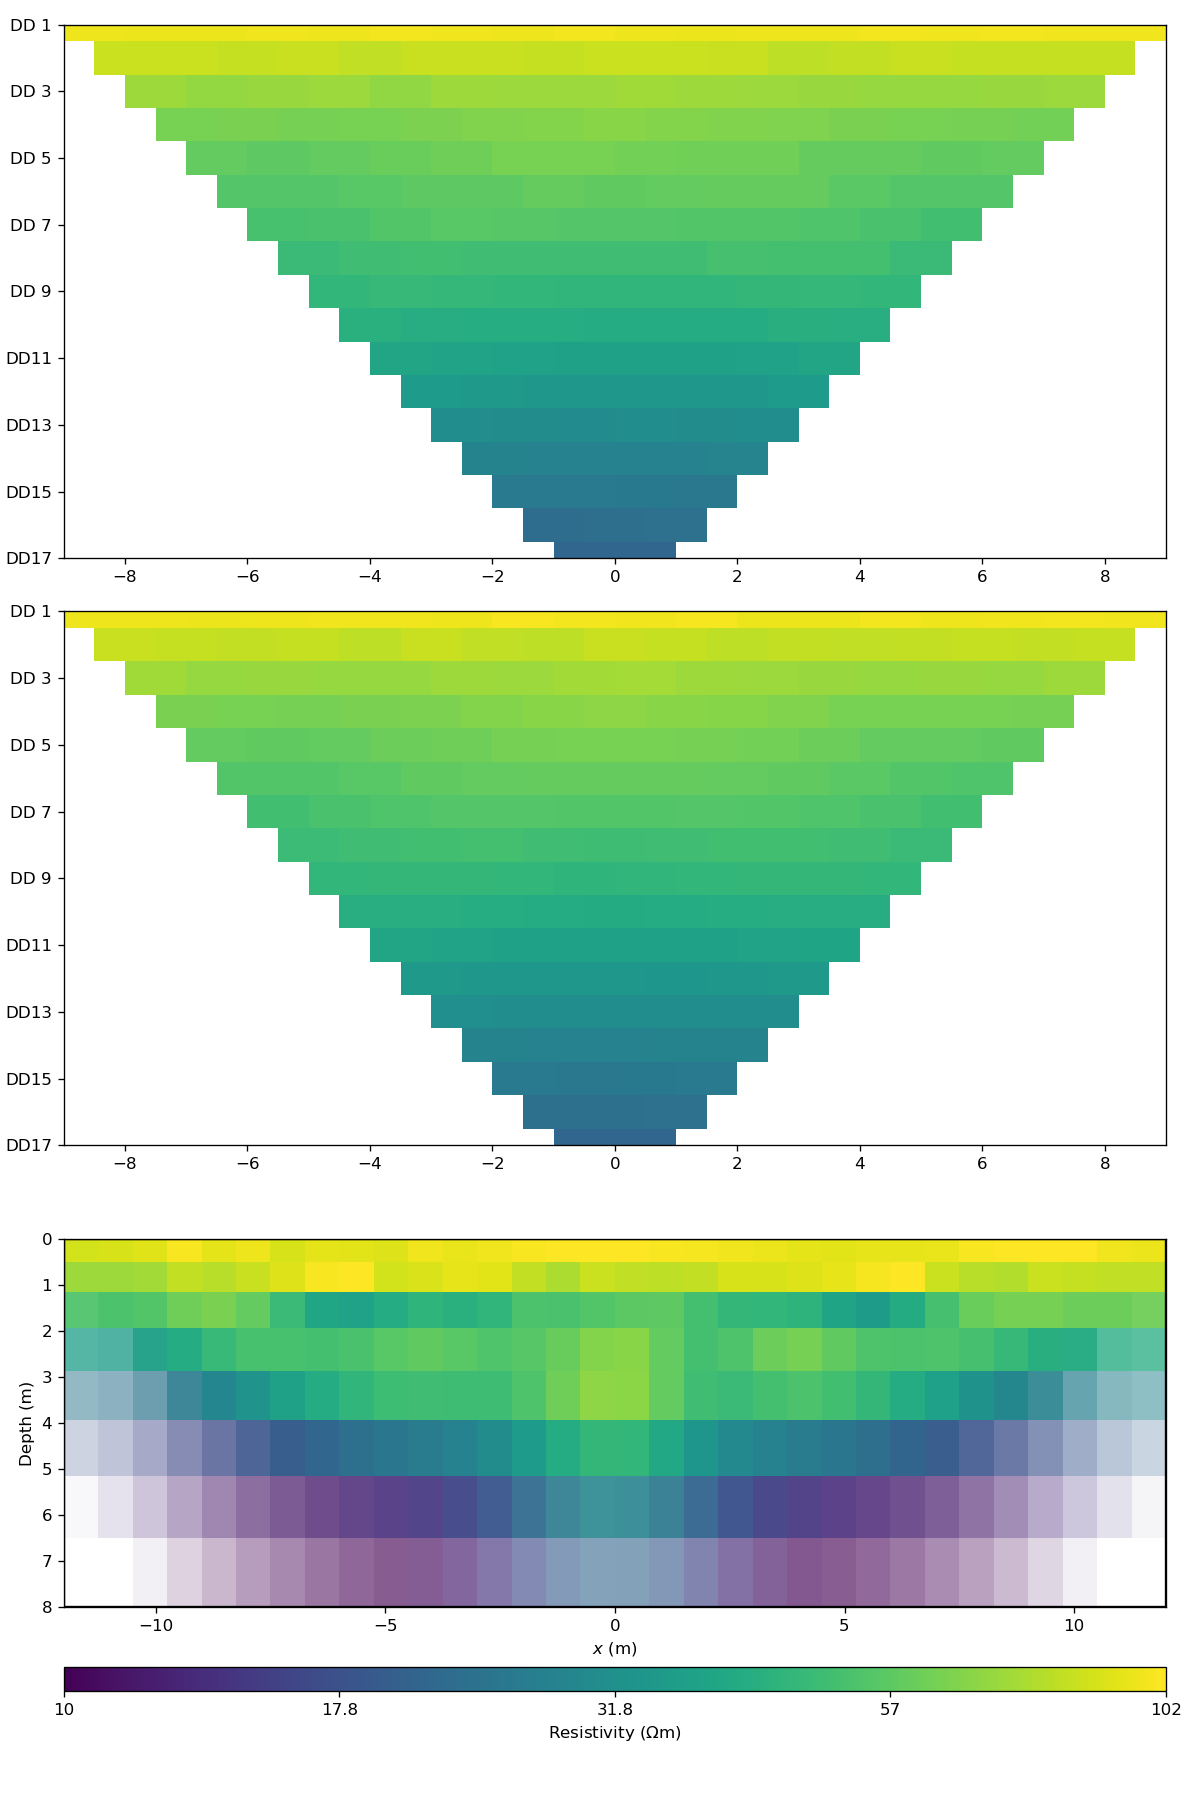

1.1646817349535479


In [13]:
grid = pg.createGrid(x=pg.utils.grange(start=-12, end=12, n=33),
                     y=-pg.utils.grange(0.5, 8, n=8, log=True))

mesh = pg.meshtools.appendTriangleBoundary(grid, xbound=50, ybound=50)

model = ert.invert(data, mesh=mesh, lam=20)
ert.showResultAndFit()

chi2 = ert.inv.getChi2()

print(chi2)
# Stop the script here and wait until all figure are closed.
pg.wait()